In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Also data visualization 
import seaborn as sns
sns.set()

In [2]:
data=pd.read_csv('fake_job_postings.csv')

In [3]:
data.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [4]:
columns = data.columns
for column in columns :
    print(column, data[column].unique().shape)

job_id (17880,)
title (11231,)
location (3106,)
department (1338,)
salary_range (875,)
company_profile (1710,)
description (14802,)
requirements (11969,)
benefits (6206,)
telecommuting (2,)
has_company_logo (2,)
has_questions (2,)
employment_type (6,)
required_experience (8,)
required_education (14,)
industry (132,)
function (38,)
fraudulent (2,)


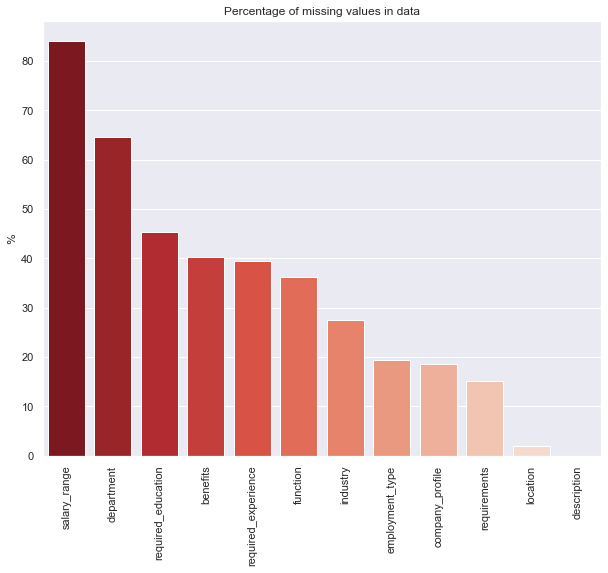

In [5]:
# check target nan value in the data 

combined = data.copy()
nan_percentage = combined.isnull().sum().sort_values(ascending=False) / combined.shape[0]
missing_val = nan_percentage[nan_percentage > 0]

plt.figure(figsize=(10,8))
sns.barplot(x=missing_val.index.values, y=missing_val.values * 100, palette="Reds_r");
plt.title("Percentage of missing values in data");
plt.ylabel("%");
plt.xticks(rotation=90);

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

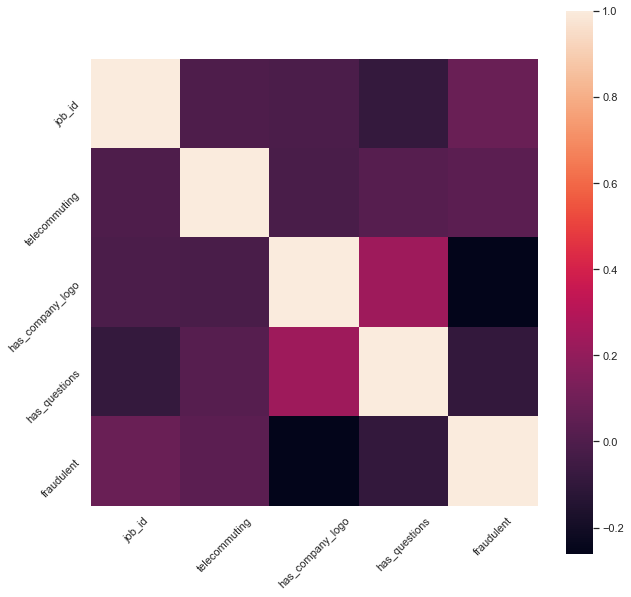

In [7]:
# Check correlation between Data
corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, :].corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr, vmax=1, square=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

In [8]:
missing_values = data.isnull().sum()
missing_values

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [9]:
newData = data.copy()
newData = newData.dropna(how="any")
newData.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,774.000000,774.000000,774.000000,774.000000,774.000000
mean,8664.093023,0.094315,0.978036,0.673127,0.093023
std,5014.106692,0.292456,0.146660,0.469374,0.290653
min,7.000000,0.000000,0.000000,0.000000,0.000000
25%,4483.500000,0.000000,1.000000,0.000000,0.000000
50%,8542.000000,0.000000,1.000000,1.000000,0.000000
75%,12922.250000,0.000000,1.000000,1.000000,0.000000
max,17866.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
new_missing_values = newData.isnull().sum()
new_missing_values

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64